# Machine Learning Earthquake Forecasting System 

How earthquakes are tracked and forecasted?

- Earthquakes are very hard to predict by nature. Some scientist believe that the quakes that are deeper and more powerful behave more cyclacally. Most of our reliable tools today come from long term histrocal forecasting and now with the help of AI we can make better predictions than before. When highly active areas are overdue for a big earthquake the AI will spot these patterns and give allerts. This method is good at identifying the most risky areas in relation to other active areas especially. There are other methods of predicting earthquakes aswell, one of which is using seismometers to track and map tyny shifts that happen in the earths crust.

How does this webapp work?

- This web application aims to forecast earthquakes that may occur around the world in the forseeble future using live earthquake data.

- This predictive model is done using XGboost which is a machine learning algorythm. The algorythm is trained using the latest monthly earthquake data pulled in from United States Geological Survey (USGC) which is updated every minute.This model preditcs the locations where earthquake may occur around the globe in the next 5 days.


Improvemnets

- It is important to note that this natural phenomona is still being studied and we still haven't found a method to predict earthqaukes with full certainty and complete accuracy hence they cause a lot od damage and kill tens of thousands of people every year.

The code for this project is open sourced and you can find it on github. Feel free to play around!

In [133]:
import numpy as np  
import pandas as pd  
from sklearn import preprocessing;
from sklearn import model_selection;
from sklearn import linear_model;
import os
import datetime as dt
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [235]:
# https://earthquake.usgs.gov/earthquakes/feed/v1.0/csv.php
# Past 30 Days
df = pd.read_csv('https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/all_month.csv')

In [258]:
df.head()
#df.shape

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2020-04-20T16:40:42.265Z,66.085400,-150.609500,1.80,1.70,ml,NaN,NaN,NaN,1.35,...,2020-04-20T16:45:22.805Z,"104km ESE of New Allakaket, Alaska",earthquake,NaN,0.30,NaN,NaN,automatic,ak,ak
1,2020-04-20T16:39:38.990Z,38.041668,-118.767502,2.56,1.75,md,13.0,179.0,0.294400,0.05,...,2020-04-20T16:41:18.358Z,"28km SE of Bodie, CA",earthquake,1.00,9.10,0.160,6.0,automatic,nc,nc
2,2020-04-20T16:38:56.020Z,38.808666,-122.824165,2.22,0.56,md,8.0,70.0,0.003922,0.01,...,2020-04-20T16:40:32.516Z,"7km WNW of The Geysers, CA",earthquake,0.43,1.09,NaN,1.0,automatic,nc,nc
3,2020-04-20T16:37:07.500Z,33.499500,-116.469000,7.18,0.66,ml,19.0,108.0,0.077640,0.20,...,2020-04-20T16:40:58.503Z,"20km ESE of Anza, CA",earthquake,0.41,1.09,0.089,13.0,automatic,ci,ci
4,2020-04-20T16:36:15.091Z,61.306400,-150.460200,31.70,1.20,ml,NaN,NaN,NaN,0.84,...,2020-04-20T16:45:22.064Z,"31km WNW of Anchorage, Alaska",earthquake,NaN,0.40,NaN,NaN,automatic,ak,ak


Check the amount of rows we have in dataframe

In [260]:

df.shape

(15510, 22)

- Plot the location of the eartquake using the longititude and latitude.

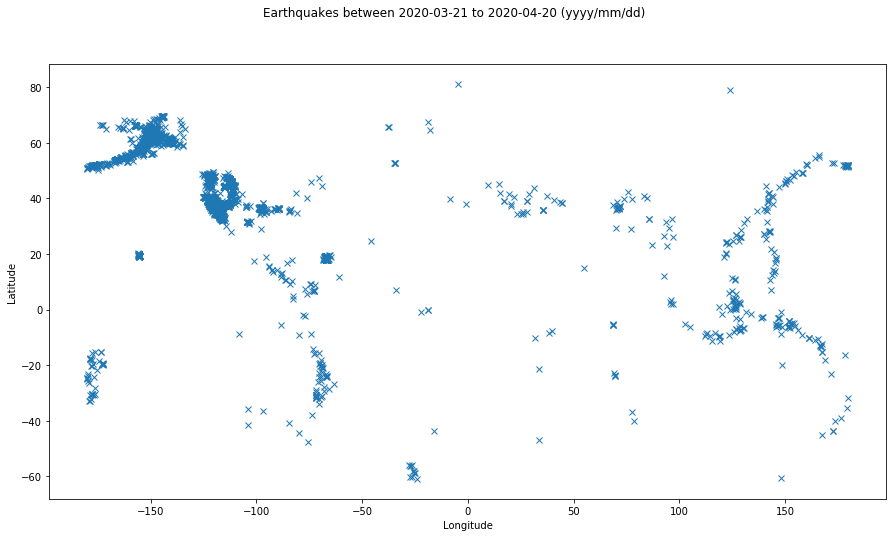

In [261]:
rounding_decimals_to = 10


fig, ax = plt.subplots(figsize=(15,8))
plt.plot(np.round(df['longitude'].head(10000),rounding_decimals_to), 
         np.round(df['latitude'].head(10000),rounding_decimals_to),
         linestyle='none', marker='x')
plt.suptitle('Earthquakes between ' + str(np.min(df['time']))[:10] + ' to ' + str(np.max(df['time']))[:10]+' (yyyy/mm/dd)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [262]:
#keep the day of the earthquake and get rid of the time for simplicity
df = df.sort_values('time', ascending=True)
df['date'] = df['time'].str[0:10]

df['date'].head()

15509    2020-03-21
15508    2020-03-21
15507    2020-03-21
15506    2020-03-21
15505    2020-03-21
Name: date, dtype: object

- We will focus our attention to the region where the earthquakes occured

In [263]:
# only keep the columns needed
df = df[['date', 'latitude', 'longitude', 'depth', 'mag', 'place']] 
#keep the country/region name only 
newdf = df['place'].str.split(', ', expand=True)
#replace the place variables with newdf
df['place'] = newdf[1]
df = df[['date', 'latitude', 'longitude', 'depth', 'mag', 'place']]
df.head()

,date,latitude,longitude,depth,mag,place
15509,2020-03-21,37.378000,-121.744333,2.15,1.16,CA
15508,2020-03-21,39.112000,-119.726300,9.90,0.10,Nevada
15507,2020-03-21,36.070833,-117.852333,2.58,1.33,CA
15506,2020-03-21,19.331167,-155.140833,1.11,3.32,Hawaii
15505,2020-03-21,33.462167,-116.396500,2.73,0.84,CA


- Count all the countries/regions where earthquakes have been detected in the past month

In [264]:
print('loacations:',len(set(df['place'])))
# s=set(df['place'])
# count=0
# for i in s:
#     count=count+1
#     print(count,i)
    

loacations: 97


- Since earthquakes can occur in multiple locations in a region.In order to simplify problem its better to average the longitude and latitude location within place/region.

In [265]:
# calculate mean lat lon for simplified locations
df_coords = df[['place', 'latitude', 'longitude']]
df_coords = df_coords.groupby(['place'], as_index=False).mean()
df_coords = df_coords[['place', 'latitude', 'longitude']]
df_coords.tail()

,place,latitude,longitude
91,Wallis and Futuna,-15.534867,-177.021800
92,Washington,47.011692,-121.990662
93,Wyoming,44.046109,-110.391085
94,Zambia,-10.390700,31.518400
95,Zimbabwe,-21.497900,33.470000


In [266]:
#merge the two dataframes
df = df[['date', 'depth', 'mag', 'place']]
df = pd.merge(left=df, right=df_coords, how='inner', on=['place'])
df.head()

,date,depth,mag,place,latitude,longitude
0,2020-03-21,2.15,1.16,CA,35.503738,-118.206001
1,2020-03-21,2.58,1.33,CA,35.503738,-118.206001
2,2020-03-21,2.73,0.84,CA,35.503738,-118.206001
3,2020-03-21,1.36,0.24,CA,35.503738,-118.206001
4,2020-03-21,7.17,1.39,CA,35.503738,-118.206001


In [267]:
print(set(df['place']))

{'Italy', 'Iran', 'Kansas', 'New York', 'Mozambique', 'Tanzania', 'Maine', 'Oregon', 'South Carolina', 'CA', 'Portugal', 'Wallis and Futuna', 'Papua New Guinea', 'Burma', 'Romania', 'Australia', 'New Zealand', 'Algeria', 'Guam', 'Texas', 'Arizona', 'Washington', 'British Virgin Islands', 'Spain', 'Argentina', 'Northern Mariana Islands', 'Pennsylvania', 'New Mexico', 'Vanuatu', 'Ecuador', 'Albania', 'Greece', 'South Georgia and the South Sandwich Islands', 'Mexico', 'Tajikistan', 'Afghanistan', 'Pakistan', 'Missouri', 'California', 'Peru', 'B.C.', 'U.S. Virgin Islands', 'East Timor', 'Puerto Rico', 'Arkansas', 'Kyrgyzstan', 'Utah', 'Nevada', 'Cayman Islands', 'Colorado', 'France', 'Chile', 'Croatia', 'North Carolina', 'Ohio', 'Wyoming', 'Tonga', 'Turkey', 'Idaho', 'Taiwan', 'Zambia', 'Oklahoma', 'Nicaragua', 'Honduras', 'Trinidad and Tobago', 'Indonesia', 'Dominican Republic', 'Japan', 'NV', 'Tennessee', 'Antigua and Barbuda', 'Mongolia', 'Venezuela', 'Micronesia', 'China', 'Syria', 'Ru

### Feature Engineering

In [268]:

#make a copy of df and set amount of days to forecast
tmp_eq = df.copy()

DAYS_OUT_TO_PREDICT = 5

# loop through each zone and apply MA
eq_data = []
eq_data_last_days_out = []

- Here we are grouping all of the individual earthquake that happen within the active region/country. This is essential as we do not want the activity of one region to be mixed with another since it will confuse our model as we need to capture the cyclical behaviour of one region independent of the other.  


- Printing the dataframe is  important here as it helps us visualise how the data is stored in dataframe.

In [274]:
for region in set(tmp_eq['place']):
    grpd_regions = tmp_eq[tmp_eq['place'] == region].copy()
    print(grpd_regions)


             date  depth  mag  place  latitude  longitude
15397  2020-04-03   10.0  4.2  Italy   41.1777  14.821375
15398  2020-04-03   10.0  4.4  Italy   41.1777  14.821375
15399  2020-04-16   10.0  4.5  Italy   41.1777  14.821375
15400  2020-04-18   10.0  4.4  Italy   41.1777  14.821375
             date  depth  mag place   latitude  longitude
14196  2020-03-22   35.0  4.2  Iran  30.240625  51.788175
14197  2020-03-27   10.0  5.3  Iran  30.240625  51.788175
14198  2020-03-27   10.0  4.2  Iran  30.240625  51.788175
14199  2020-03-27   10.0  4.5  Iran  30.240625  51.788175
             date  depth  mag   place   latitude  longitude
14784  2020-03-22    5.0  3.1  Kansas  38.200213 -97.296537
14785  2020-03-24    5.0  3.3  Kansas  38.200213 -97.296537
14786  2020-03-25    5.0  2.3  Kansas  38.200213 -97.296537
14787  2020-03-30    5.0  2.2  Kansas  38.200213 -97.296537
14788  2020-03-30    5.0  2.5  Kansas  38.200213 -97.296537
14789  2020-03-30    5.0  2.2  Kansas  38.200213 -97.296537


             date  depth  mag         place  latitude  longitude
15418  2020-04-09    5.0  1.3  Pennsylvania   40.3273   -75.9662
             date  depth  mag       place   latitude   longitude
15386  2020-04-01   8.58  2.9  New Mexico  31.684543 -104.437614
15387  2020-04-03   5.00  2.7  New Mexico  31.684543 -104.437614
15388  2020-04-12   5.00  3.4  New Mexico  31.684543 -104.437614
15389  2020-04-12   5.00  2.7  New Mexico  31.684543 -104.437614
15390  2020-04-13   6.14  2.9  New Mexico  31.684543 -104.437614
15391  2020-04-13   5.00  2.7  New Mexico  31.684543 -104.437614
15392  2020-04-16   5.00  3.1  New Mexico  31.684543 -104.437614
             date   depth  mag    place   latitude   longitude
15152  2020-03-23  108.28  4.7  Vanuatu -15.233236  167.645307
15153  2020-03-24  228.60  4.5  Vanuatu -15.233236  167.645307
15154  2020-03-28   10.00  4.8  Vanuatu -15.233236  167.645307
15155  2020-03-28   84.00  5.8  Vanuatu -15.233236  167.645307
15156  2020-03-31   40.33  4.5  Van

             date  depth   mag  place   latitude   longitude
13518  2020-03-21  11.23  0.93  Idaho  44.327631 -115.033757
13519  2020-03-23   6.00  0.56  Idaho  44.327631 -115.033757
13520  2020-03-26   7.67  0.40  Idaho  44.327631 -115.033757
13521  2020-03-26   7.65  0.39  Idaho  44.327631 -115.033757
13522  2020-03-27  10.85  1.03  Idaho  44.327631 -115.033757
...           ...    ...   ...    ...        ...         ...
14022  2020-04-19  10.00  2.80  Idaho  44.327631 -115.033757
14023  2020-04-19  10.00  2.50  Idaho  44.327631 -115.033757
14024  2020-04-20  10.00  2.50  Idaho  44.327631 -115.033757
14025  2020-04-20  10.00  2.70  Idaho  44.327631 -115.033757
14026  2020-04-20  10.00  2.70  Idaho  44.327631 -115.033757

[509 rows x 6 columns]
             date  depth  mag   place  latitude  longitude
15416  2020-04-08  25.09  4.4  Taiwan  24.15305    122.047
15417  2020-04-12  37.09  4.6  Taiwan  24.15305    122.047
             date  depth  mag   place  latitude  longitude
15427  2

            date  depth   mag   place   latitude   longitude
7050  2020-03-21   1.11  3.32  Hawaii  19.269251 -155.417672
7051  2020-03-21   6.82  2.22  Hawaii  19.269251 -155.417672
7052  2020-03-21  38.05  2.08  Hawaii  19.269251 -155.417672
7053  2020-03-21  38.15  2.01  Hawaii  19.269251 -155.417672
7054  2020-03-21  31.35  1.99  Hawaii  19.269251 -155.417672
...          ...    ...   ...     ...        ...         ...
7561  2020-04-20  26.50  1.87  Hawaii  19.269251 -155.417672
7562  2020-04-20  35.48  2.15  Hawaii  19.269251 -155.417672
7563  2020-04-20  32.37  2.50  Hawaii  19.269251 -155.417672
7564  2020-04-20   3.65  1.88  Hawaii  19.269251 -155.417672
7565  2020-04-20  32.86  1.97  Hawaii  19.269251 -155.417672

[516 rows x 6 columns]
             date  depth  mag           place  latitude  longitude
15251  2020-03-24   10.0  4.9  Ecuador region   2.44465  -95.36945
15252  2020-03-28   10.0  4.5  Ecuador region   2.44465  -95.36945
             date  depth  mag      place   

In [271]:
# To see the earthquake occurences within this month 
for region in set(tmp_eq['place']):
    grpd_regions = tmp_eq[tmp_eq['place'] == region].copy()
    g=grpd_regions.shape
    print(region,'=', g[0])

Italy = 4
Iran = 4
Kansas = 8
New York = 1
Mozambique = 1
Tanzania = 2
Maine = 1
Oregon = 81
South Carolina = 1
CA = 6392
Portugal = 1
Wallis and Futuna = 3
Papua New Guinea = 42
Burma = 2
Romania = 1
Australia = 1
New Zealand = 23
Algeria = 1
Guam = 3
Texas = 24
Arizona = 1
Washington = 259
British Virgin Islands = 1
Spain = 1
Argentina = 23
Northern Mariana Islands = 24
Pennsylvania = 1
New Mexico = 7
Vanuatu = 14
Ecuador = 4
Albania = 1
Greece = 17
South Georgia and the South Sandwich Islands = 11
Mexico = 11
Tajikistan = 9
Afghanistan = 15
Pakistan = 1
Missouri = 8
California = 243
Peru = 8
B.C. = 16
U.S. Virgin Islands = 1
East Timor = 4
Puerto Rico = 855
Arkansas = 7
Kyrgyzstan = 3
Utah = 1037
Nevada = 658
Cayman Islands = 3
Colorado = 14
France = 2
Chile = 52
Croatia = 9
North Carolina = 2
Ohio = 1
Wyoming = 71
Tonga = 26
Turkey = 9
Idaho = 509
Taiwan = 2
Zambia = 1
Oklahoma = 201
Nicaragua = 3
Honduras = 5
Trinidad and Tobago = 1
Indonesia = 101
Dominican Republic = 16
Japan = 

- What we will do now is take the rolling moving averages of the earthquakes depths and magnitude according to the region. This is done to turn the the event based data into a time series to spot the cyclical nature of these earthquakes.

- We will use a fast (5 day MA), medium (10 day MA) and slow (20 day MA) moving averages to help spot these cycles.

- We will also make a new column (mag_outcome) which is the fast day MA shifted up by 5 days. As a result the the first row in mag_avg_5 column will be inline with the 5th value of mag_avg_5 under the new column 'mag_outcome'. The new column is essentially peeking into the future by the amount of days we are looking to predict. 

- It is important to understand that we cant use this column to predict live data as we cannot look into the future but we are only using it in order to train the model.

In [308]:
tmp_eq = df.copy()

DAYS_OUT_TO_PREDICT = 5

# loop through each region as we did before and apply MA
eq_data = []
eq_data_last_days_out = []
for place in list(set(eq_tmp['place'])):
    temp_df = eq_tmp[eq_tmp['place'] == place].copy()
    temp_df['depth_avg_20'] = temp_df['depth'].rolling(window=20,center=False).mean() 
    temp_df['depth_avg_10'] = temp_df['depth'].rolling(window=10,center=False).mean()
    temp_df['depth_avg_5'] = temp_df['depth'].rolling(window=5,center=False).mean()
    temp_df['mag_avg_20'] = temp_df['mag'].rolling(window=20,center=False).mean() 
    temp_df['mag_avg_10'] = temp_df['mag'].rolling(window=10,center=False).mean()
    temp_df['mag_avg_5'] = temp_df['mag'].rolling(window=5,center=False).mean()
    
    
    #Make new column that peeks into the future by x days
    temp_df['mag_outcome'] = temp_df['mag_avg_5'].shift(DAYS_OUT_TO_PREDICT * -1)
    
    #append the last few days in dataframe for which we don't have mag_outcome 
    #data for --> they become our live data
    eq_data_last_days_out.append(temp_df.tail(DAYS_OUT_TO_PREDICT))

    eq_data.append(temp_df)


- Here, we will join the dataframes together by calling the concat function in pandas.

- Also, there is going to be a lot of NaN in the lists created as some regions do not have many earthquake occurences as seen before. 

- Moreover, when we apply the MA, the first few values are going to NaN. For example the first 20 values for depth_avg_20 column are going to be NaN for all regions as we need to go through 20 datapoints from depth column to get the first depth_avg_20 reading. Hence we will not have the first 20 readings for the depth_avg_20 or the mag_avg_20. 

- The best thing to do is to remove these NaN so that they dont effect our model in the long run.

In [317]:
# join all dataframes into one
eq_all = pd.concat(eq_data)

# remove any NaN fields
eq_all = eq_all[np.isfinite(eq_all['depth_avg_20'])]
eq_all = eq_all[np.isfinite(eq_all['mag_avg_20'])]
eq_all = eq_all[np.isfinite(eq_all['mag_outcome'])]

In [318]:
eq_data_last_days_out

,date,depth,mag,place,latitude,longitude,depth_avg_20,depth_avg_10,depth_avg_5,mag_avg_20,mag_avg_10,mag_avg_5,mag_outcome
14300,2020-04-14,28.19,1.07,Oregon,44.799762,-121.917786,8.3770,11.013,15.594,0.6155,0.869,1.334,NaN
14301,2020-04-14,-1.39,1.47,Oregon,44.799762,-121.917786,7.9810,10.179,14.818,0.6555,0.962,1.306,NaN
14302,2020-04-16,2.76,1.11,Oregon,44.799762,-121.917786,7.8380,9.814,14.120,0.7150,1.041,1.582,NaN
14303,2020-04-16,-0.37,1.41,Oregon,44.799762,-121.917786,7.6520,9.081,5.534,0.8025,1.143,1.362,NaN
14304,2020-04-17,-1.82,2.17,Oregon,44.799762,-121.917786,7.2640,8.296,5.474,0.8980,1.307,1.446,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14428,2020-04-17,1.40,1.30,Canada,58.840828,-129.576121,8.9870,8.678,7.836,1.5960,1.401,1.362,NaN
14429,2020-04-17,-0.37,2.10,Canada,58.840828,-129.576121,8.7195,7.541,6.762,1.5820,1.471,1.382,NaN
14430,2020-04-19,5.13,0.23,Canada,58.840828,-129.576121,6.9535,6.944,4.362,1.5070,1.364,1.088,NaN
14431,2020-04-19,39.75,1.59,Canada,58.840828,-129.576121,8.9210,9.819,12.362,1.5065,1.393,1.244,NaN


In [319]:
#list most active regions that we can predict on in past month
active_regions=set(eq_all['place'])
print('Most active region : \n', active_regions)

Most active region : 
 {'Montana', 'Wyoming', 'Tonga', 'Idaho', 'Oklahoma', 'California', 'Oregon', 'CA', 'Papua New Guinea', 'Philippines', 'Indonesia', 'New Zealand', 'Puerto Rico', 'Japan', 'Hawaii', 'Texas', 'Utah', 'Nevada', 'Washington', 'Canada', 'Chile', 'Russia', 'Alaska'}


- We can plot the Dataframe we created using the longitude and latitude. We can see that we have simplified the data significantly as we have much fewer points to track during this month. The regions where we didn't have much data to predict on using our MA and mag_outcome have been eliminated. 

- Most if not all remaining regions are the most active zones based on historical data aswell. 

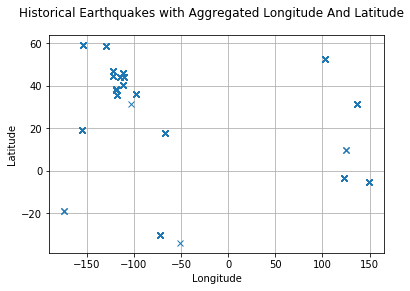

In [320]:
plt.plot(eq_all['longitude'], 
         eq_all['latitude'],
         linestyle='none', marker='x')
plt.suptitle('Historical Earthquakes with Aggregated Longitude And Latitude')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid()
plt.show()


### Live data

- We will join the live data into one master dataframe as we did with the historical data and also remove the NaN for the all columns expet mag outcome. 
- We will be leaving the mag_outcome collumn as the live data will fill in those values. 

In [474]:
# keep our live data for predictions
eq_data_last_days_out = pd.concat(eq_data_last_days_out)
eq_data_last_days_out = eq_data_last_days_out[np.isfinite(eq_data_last_days_out['mag_avg_20'])]

TypeError: first argument must be an iterable of pandas objects, you passed an object of type "DataFrame"

In [322]:
eq_data_last_days_out.head(20)

,date,depth,mag,place,latitude,longitude,depth_avg_20,depth_avg_10,depth_avg_5,mag_avg_20,mag_avg_10,mag_avg_5,mag_outcome
14300,2020-04-14,28.19,1.07,Oregon,44.799762,-121.917786,8.3770,11.013,15.594,0.6155,0.869,1.334,NaN
14301,2020-04-14,-1.39,1.47,Oregon,44.799762,-121.917786,7.9810,10.179,14.818,0.6555,0.962,1.306,NaN
14302,2020-04-16,2.76,1.11,Oregon,44.799762,-121.917786,7.8380,9.814,14.120,0.7150,1.041,1.582,NaN
14303,2020-04-16,-0.37,1.41,Oregon,44.799762,-121.917786,7.6520,9.081,5.534,0.8025,1.143,1.362,NaN
14304,2020-04-17,-1.82,2.17,Oregon,44.799762,-121.917786,7.2640,8.296,5.474,0.8980,1.307,1.446,NaN
7110,2020-04-20,2.68,2.00,CA,35.512021,-118.214014,5.4445,4.587,5.390,1.1700,1.260,1.308,NaN
7111,2020-04-20,5.18,0.69,CA,35.512021,-118.214014,5.3640,5.187,4.604,1.1275,1.268,1.248,NaN
7112,2020-04-20,1.95,1.07,CA,35.512021,-118.214014,5.2435,4.635,4.160,1.1240,1.152,1.096,NaN
7113,2020-04-20,2.54,2.05,CA,35.512021,-118.214014,5.1045,4.258,2.782,1.1380,1.208,1.228,NaN
7114,2020-04-20,-0.61,1.65,CA,35.512021,-118.214014,4.6215,4.026,2.348,1.1550,1.323,1.492,NaN


- By calling the describe function to the magnitude column, we can see the spread of the readings we have procured.

In [323]:
print(eq_all['mag'].describe())

count    14327.000000
mean         1.193494
std          0.978438
min         -1.820000
25%          0.560000
50%          1.050000
75%          1.730000
max          5.900000
Name: mag, dtype: float64


- 75% of the data is below magnitude two, we will use a magnitude of two to be the cutoff point for which we calssify an earthquake in our model.This is done numerically , 1 for earthquake occured else 0 for no earthquake.

In [324]:
eq_all['mag_outcome'] = np.where(eq_all['mag_outcome'] > 2, 1,0)
print(eq_all['mag_outcome'].describe())

count    14327.000000
mean         0.133664
std          0.340303
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: mag_outcome, dtype: float64


- We can see that only 13% of the data is classified as earthquake out of whe whole dataset.

In [325]:
eq_all['mag_outcome']

14242    0
14243    0
14244    0
14245    1
14246    1
        ..
14423    0
14424    0
14425    0
14426    0
14427    0
Name: mag_outcome, Length: 14327, dtype: int32

In [326]:
eq_all


,date,depth,mag,place,latitude,longitude,depth_avg_20,depth_avg_10,depth_avg_5,mag_avg_20,mag_avg_10,mag_avg_5,mag_outcome
14242,2020-04-02,23.01,1.14,Oregon,44.799762,-121.917786,5.5730,5.710,7.020,1.3815,1.454,1.714,0
14243,2020-04-02,-0.19,1.25,Oregon,44.799762,-121.917786,5.0635,4.747,7.094,1.3090,1.474,1.542,0
14244,2020-04-03,16.36,1.05,Oregon,44.799762,-121.917786,5.7860,6.098,10.428,1.3870,1.513,1.460,0
14245,2020-04-03,-0.54,1.22,Oregon,44.799762,-121.917786,5.8180,6.061,7.596,1.3985,1.457,1.190,1
14246,2020-04-03,-0.39,1.96,Oregon,44.799762,-121.917786,5.8160,6.180,7.650,1.3975,1.477,1.324,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14423,2020-04-14,4.50,1.50,Canada,58.840828,-129.576121,8.0695,7.782,9.520,1.7280,1.506,1.440,0
14424,2020-04-14,5.00,2.00,Canada,58.840828,-129.576121,8.1695,8.202,8.320,1.7530,1.476,1.560,0
14425,2020-04-16,17.13,1.70,Canada,58.840828,-129.576121,9.0010,9.255,9.526,1.7730,1.496,1.640,0
14426,2020-04-16,-0.25,0.81,Canada,58.840828,-129.576121,8.4885,7.420,7.276,1.6685,1.477,1.542,0


### XGBoost algorythm

- When using a model to predict on a specific use case , the rarer the occurences the more harder it is to model it genrally speaking. XGboost is a good model to predict these rare outcome variables. XGboost is extensively used in many different application across industries and Kaggle competitions. It can do logistical regression, linear regression and multiclassification and other types of learning. XGboost uses boosted engines which makes it quite fast aswell.

In [303]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [411]:
 
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [329]:
import xgboost as xgb
from sklearn.model_selection import train_test_split



- Take out the columns that are text based such as in the place column. 
- It's advisable to remove colums that could potentially confuse our model when forecasting; columns such as the longititude and latitude as they are not timeseries data.You also need to make sure you don't add the y label in features(mag_outcome)


In [330]:
#make fearure data--> x
features = [f for f in list(eq_all) if f not in ['date', 'lon_box_mean',
 'lat_box_mean', 'mag_outcome', 'mag', 'place',
 'combo_box_mean',  'latitude',
 'longitude']]

In [331]:
features


['depth',
 'depth_avg_20',
 'depth_avg_10',
 'depth_avg_5',
 'mag_avg_20',
 'mag_avg_10',
 'mag_avg_5']

- Split the data for 70% train and 30% test. Pass the features columns as x label and the mag_outcome as y label. 

*random state is used for reproducibilty purposes -> so that if we were to reproduce the model
we will use the same datapoints that were used for the train and test datasets. 


In [332]:
#  split Dataset

X_train, X_test, y_train, y_test = train_test_split(eq_all[features],
                     eq_all['mag_outcome'], test_size=0.3, random_state=42)



Xgboost uses their own matrix system rather than using numpy. Make sure you fit the x train,y_train and x_test,y_test using the DMatrix function. 

- The X_train and y_train will be used to just train the model (by analysing relationship between datapoints).


- We will use the X_test and Y_test in order to test the model accuracy. Once we have trained our model we will pass the X_test variables and see what the model predicts for the Y variable. We will then compare the models Y variables with the real Y_test variables and asses accuracy. The evaluation metric we have used for this model is AUC(area under the curve), if the model we were using had been regresion we would use RMSE(root mean square error)


In [333]:
#To train model--> [Only training and learning occurs here]
dtrain = xgb.DMatrix(X_train[features], label=y_train)
#To test model--> []
dtest = xgb.DMatrix(X_test[features], label=y_test)

param = {
        'objective': 'binary:logistic', #Logistic regression model
        'booster': 'gbtree',
        'eval_metric': 'auc',
        'max_depth': 3,  # the maximum depth of each tree
        'eta': 0.1,  # the training step for each iteration
        'silent': 1}  # logging mode - quiet}  # the number of classes that exist in this datset

In [334]:
num_round = 500  # the number of training iterations    
early_stopping_rounds=30 #if model doesnt improve after 30 rounds stop model straight away


#pass the parameter, the training dataset and number of rounds to train
bst = xgb.train(param, dtrain, num_round) #bst is the trained model

# pass the test dataset to you boost model using the predict function 
preds = bst.predict(dtest) 


# Quick way to see the percentage of earthquakes that are classified as eartquakes from dataset
np.mean(preds)

0.12734565



- Test the accuracy of model by passing the model predicted values and actual y_test values to the AUC evaluation metric. 

In [335]:
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve, auc

#print (auc(y_test, preds))
fpr, tpr, _ = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)
print('AUC:', np.round(roc_auc,2)) 

AUC: 0.98


- We can see that our model is ~90% acurate, taking into factor all the feature engineering and simplification of the dataset we procured. This result is satisfactory and we can say that model bst is good enough to be used for live data. 

- We can also use the fscore to see which columns are of the highest importance when the bst model makes a prediction. If we have features that are of litle significance we can remove them as they may add confusion and use more processing power.


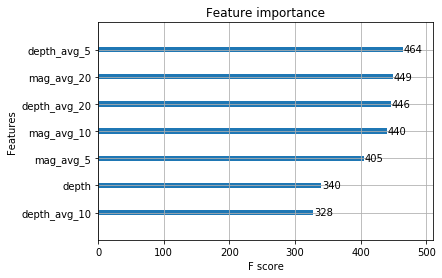

In [356]:

xgb.plot_importance(bst)


In [349]:
# To print fscore in a dataframe[alternative method] 
def get_xgb_imp(xgb, feat_names):
    #get the features fscore 
    imp_vals = xgb.get_fscore()
    print(imp_vals)
    #put fscores according to features into dataframe 
    feats_imp = pd.DataFrame(imp_vals,index=np.arange(2)).T
    #make the features the index of df 
    feats_imp.iloc[:,0]= feats_imp.index    
    #Name and sort values
    feats_imp.columns=['feature','importance']
    feats_imp.sort_values('importance',inplace=True,ascending=False)
    feats_imp.reset_index(drop=True,inplace=True)
    return feats_imp

feature_importance_df = get_xgb_imp(bst, features)
feature_importance_df

{'mag_avg_20': 449, 'mag_avg_5': 405, 'depth_avg_5': 464, 'depth_avg_20': 446, 'depth': 340, 'depth_avg_10': 328, 'mag_avg_10': 440}


,feature,importance
0,depth_avg_5,464
1,mag_avg_20,449
2,depth_avg_20,446
3,mag_avg_10,440
4,mag_avg_5,405
5,depth,340
6,depth_avg_10,328


- Now we can take our trained model and pass our live data in order to predict the earthquakes in the next 5 days.

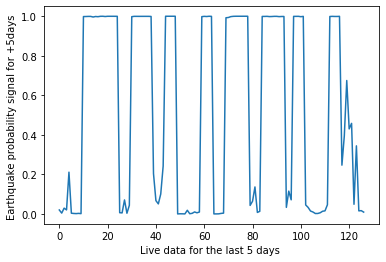

In [458]:
# change live data to the xgb Dmatrix format first
dlive = xgb.DMatrix(eq_data_last_days_out[features]) 
#pass the live data to our trained model
preds = bst.predict(dlive) #--> mag_outcome of the upcoming 5 days 

#plot outcome
plt.plot(preds)
plt.xlabel('Live data for the last 5 days ')
plt.ylabel('Earthquake probability signal for +5days ')
plt.show()



- Add the quake prediction to the live dataframe in order for quake to correspond to the place/region.
- We need to realise that the quake predictions are +5 days predictions from the date column.

In [404]:
live_set = eq_data_last_days_out[['date', 'place', 'latitude', 'longitude']]
live_set['quake'] = preds
live_set.tail()

,date,place,latitude,longitude,quake
14428,2020-04-17,Canada,58.840828,-129.576121,0.048734
14429,2020-04-17,Canada,58.840828,-129.576121,0.344357
14430,2020-04-19,Canada,58.840828,-129.576121,0.015511
14431,2020-04-19,Canada,58.840828,-129.576121,0.016574
14432,2020-04-19,Canada,58.840828,-129.576121,0.009186


In [405]:
# aggregate rows that have the same place and datetime into one to avoid duplicates
live_set = live_set.groupby(['date', 'place'], as_index=False).mean()

- In order for the quake column to correspond to the actual data it is forecasting an earthquake we need to increase the live data date column by 5 days.

In [406]:
# increment date to include DAYS_OUT_TO_PREDICT

#set date column as datetime
live_set['date']= pd.to_datetime(live_set['date'],format='%Y-%m-%d') 

#increase the date column by days out to predict [5]
live_set['date'] = live_set['date'] + pd.to_timedelta(DAYS_OUT_TO_PREDICT,unit='d')

live_set.tail()

,date,place,latitude,longitude,quake
57,2020-04-25,Idaho,44.327160,-115.030786,0.999911
58,2020-04-25,Japan,31.297988,136.459104,0.998718
59,2020-04-25,Oklahoma,36.227721,-97.832872,0.010365
60,2020-04-25,Puerto Rico,17.984202,-66.864334,0.999950
61,2020-04-25,Washington,46.997200,-121.994875,0.043435


In [407]:
live_set.tail()

,date,place,latitude,longitude,quake
57,2020-04-25,Idaho,44.327160,-115.030786,0.999911
58,2020-04-25,Japan,31.297988,136.459104,0.998718
59,2020-04-25,Oklahoma,36.227721,-97.832872,0.010365
60,2020-04-25,Puerto Rico,17.984202,-66.864334,0.999950
61,2020-04-25,Washington,46.997200,-121.994875,0.043435


In [408]:
#Put the future dates into a list of strings 
days = list(set([d for d in live_set['date'].astype(str) if d > dt.datetime.today().strftime('%Y-%m-%d')]))
days.sort()
days

['2020-04-23', '2020-04-24', '2020-04-25']

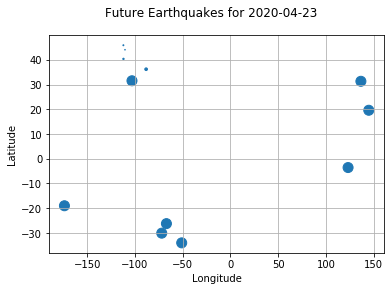

In [409]:
# see how our map will look using probability intensities
predict_day='2020-04-23'

#Pulls the rows for that correspond to that datetime(predict_day)
live_set_tmp = live_set[live_set['date'] == predict_day]

plt.scatter(live_set_tmp['longitude'], 
         live_set_tmp['latitude'], s=(live_set_tmp['quake'] * 100))
plt.suptitle('Future Earthquakes for ' + predict_day)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid()
plt.show()

- We can make a wordcloud of the locations where the earthquakes are predicted to occur for quick visualisation and comprehension.

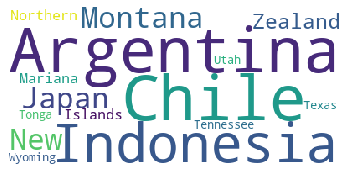

In [453]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

t=[]
for i in live_set_tmp['place']:
    s=i+' '
    t.append(s)
    pass
    
d=''.join(t)
d


cloud= WordCloud(background_color='white').generate(d)
plt.imshow(cloud)
plt.axis('off')
plt.show()

#### Web app

We have finished and outlined the main components of the application, now we just have to compile all the lines of code into one function that we can call.



In [475]:
import xgboost as xgb
    
def prepare_earthquake_data_and_model(days_out_to_predict = 5, max_depth=3, eta=0.1):
    import pandas as pd
    import numpy as np
    # get latest data from USGS servers
    df = pd.read_csv('https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/all_month.csv')
    df = df.sort_values('time', ascending=True)
    # truncate time from datetime
    df['date'] = df['time'].str[0:10]
    
    # only keep the columns needed
    df = df[['date', 'latitude', 'longitude', 'depth', 'mag', 'place']]
    temp_df = df['place'].str.split(', ', expand=True) 
    df['place'] = temp_df[1]
    df = df[['date', 'latitude', 'longitude', 'depth', 'mag', 'place']]

    # calculate mean lat lon for simplified locations
    df_coords = df[['place', 'latitude', 'longitude']]
    df_coords = df_coords.groupby(['place'], as_index=False).mean()
    df_coords = df_coords[['place', 'latitude', 'longitude']]

    df = df[['date', 'depth', 'mag', 'place']]
    df = pd.merge(left=df, right=df_coords, how='inner', on=['place'])
    
    # loop through each zone and apply MA
    eq_data = []
    df_live = []
    for symbol in list(set(df['place'])):
        temp_df = df[df['place'] == symbol].copy()
        temp_df['depth_avg_20'] = temp_df['depth'].rolling(window=20,center=False).mean() 
        temp_df['depth_avg_10'] = temp_df['depth'].rolling(window=10,center=False).mean()
        temp_df['depth_avg_5'] = temp_df['depth'].rolling(window=5,center=False).mean()
        temp_df['mag_avg_20'] = temp_df['mag'].rolling(window=20,center=False).mean() 
        temp_df['mag_avg_10'] = temp_df['mag'].rolling(window=10,center=False).mean()
        temp_df['mag_avg_5'] = temp_df['mag'].rolling(window=5,center=False).mean()
        temp_df.loc[:, 'mag_outcome'] = temp_df.loc[:, 'mag_avg_5'].shift(days_out_to_predict * -1)

        df_live.append(temp_df.tail(days_out_to_predict))

        eq_data.append(temp_df)

    # concat all location-based dataframes into master dataframe
    df = pd.concat(eq_data)

    # remove any NaN fields
    df = df[np.isfinite(df['depth_avg_20'])]
    df = df[np.isfinite(df['mag_avg_20'])]
    df = df[np.isfinite(df['mag_outcome'])]

    # prepare outcome variable
    df['mag_outcome'] = np.where(df['mag_outcome'] > 2.5, 1,0)
 
    df = df[['date',
             'latitude',
             'longitude',
             'depth_avg_20',
             'depth_avg_10',
             'depth_avg_5',
             'mag_avg_20', 
             'mag_avg_10',
             'mag_avg_5',
             'mag_outcome']]

    # keep only data where we can make predictions
    df_live = pd.concat(df_live)
    df_live = df_live[np.isfinite(df_live['mag_avg_20'])]
    
    # let's train the model whenever the webserver is restarted
    from sklearn.model_selection import train_test_split
    features = [f for f in list(df) if f not in ['date', 'mag_outcome', 'latitude',
     'longitude']]

    X_train, X_test, y_train, y_test = train_test_split(df[features],
                         df['mag_outcome'], test_size=0.3, random_state=42)

    dtrain = xgb.DMatrix(X_train[features], label=y_train)
    dtest = xgb.DMatrix(X_test[features], label=y_test)

    param = {
            'objective': 'binary:logistic',
            'booster': 'gbtree',
            'eval_metric': 'auc',
            'max_depth': max_depth,  # the maximum depth of each tree
            'eta': eta,  # the training step for each iteration
            'silent': 1}  # logging mode - quiet}  # the number of classes that exist in this datset

    num_round = 500  # the number of training iterations    
    early_stopping_rounds=30
    xgb_model = xgb.train(param, dtrain, num_round) 
    

    # train on live data
    dlive = xgb.DMatrix(df_live[features])  
    preds = xgb_model.predict(dlive)

    # add preds to live data
    df_live = df_live[['date', 'place', 'latitude', 'longitude']]
    # add predictions back to dataset 
    df_live = df_live.assign(preds=pd.Series(preds).values)

    # aggregate down dups
    df_live = df_live.groupby(['date', 'place'], as_index=False).mean()
 
    # increment date to include DAYS_OUT_TO_PREDICT
    df_live['date']= pd.to_datetime(df_live['date'],format='%Y-%m-%d') 
    df_live['date'] = df_live['date'] + pd.to_timedelta(days_out_to_predict,unit='d')

    return(df_live)

df_live = prepare_earthquake_data_and_model()
df_live.tail()

,date,place,latitude,longitude,preds
41,2020-04-29,Oregon,44.834473,-121.789498,0.000216
42,2020-04-29,Puerto Rico,17.992204,-66.861067,0.961500
43,2020-04-29,Utah,40.026683,-112.074557,0.000112
44,2020-04-29,Washington,46.919580,-121.975461,0.000170
45,2020-04-29,Wyoming,44.063727,-110.424873,0.001247


******Important Notice

When making a web application reboot your server once a day. Don't  excute all the code everytime user changes the prediction date as this will be very taxing on your server and can cause an extended delay.



In [461]:
from datetime import datetime
datetime_object = datetime.strptime("04/27/2020", '%m/%d/%Y')
list(set([d for d in df_live['date'] if d == datetime_object]))

[Timestamp('2020-04-27 00:00:00')]

The following function gets called whenever the user changes the date to see predictions. This function will take the desired date and pull it off the live data

In [468]:
def get_earth_quake_estimates(desired_date, df_live):
    from datetime import datetime
    datetime_object = desired_date #datetime.strptime(desired_date, '%m/%d/%Y')
    live_set_tmp = df_live[df_live['date'] == datetime_object]
    
    # format lat/lons like Google Maps expects
    LatLngString = ''
    if (len(live_set_tmp) > 0):
        for lat, lon, pred in zip(live_set_tmp['latitude'], live_set_tmp['longitude'], live_set_tmp['preds']): 
            # this is the threashold of probability to decide what to show and what not to show
            if (pred > 0.3):
                LatLngString += "new google.maps.LatLng(" + str(lat) + "," + str(lon) + "),"
        
    return(LatLngString)
 
get_earth_quake_estimates(datetime.strptime("04/23/2020", '%m/%d/%Y'), df_live)

'new google.maps.LatLng(-26.358996,-67.158856),new google.maps.LatLng(-29.144682352941164,-71.63803137254904),new google.maps.LatLng(-3.2519020833333343,123.061903125),new google.maps.LatLng(-34.12124074074074,-47.23328888888889),new google.maps.LatLng(-18.967576923076926,-173.73385000000005),'

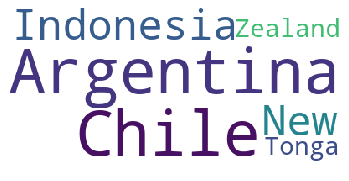

In [473]:
def cloudword_generator(desired_date, df_live):
    datetime_object = desired_date #datetime.strptime(desired_date, '%m/%d/%Y')
    live_set_tmp = df_live[df_live['date'] == datetime_object]
    
    locations=[]
    for i in live_set_tmp['place']:
        place=i+' '
        locations.append(place)
        pass
    
    combined_locations=''.join(locations)
    
    cloud_locations= WordCloud(background_color='white').generate(combined_locations)
    
    plt.imshow(cloud_locations)
    plt.axis('off')
    plt.show()
    
    return cloud_locations


cloudword_generator(datetime.strptime("04/23/2020", '%m/%d/%Y'), df_live)    
    

In [104]:
# pull future predictions
from datetime import timedelta
horizon_date = datetime.today() + timedelta(days=0)
print(str(horizon_date)[:10])
get_earth_quake_estimates(str(horizon_date)[:10], df_live)

2019-12-17


'new google.maps.LatLng(19.341037037037037,-64.52797407407408),new google.maps.LatLng(34.96731428571429,93.43650952380953),new google.maps.LatLng(36.31993181818182,23.146681818181822),new google.maps.LatLng(17.633923809523807,-98.38377142857144),'